In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
def simGP(SN, irf, noise):

    length = (len(irf)-1)*2

    ts = np.zeros(length)
    ts[length//2] += 1

    ts_convolved = np.fft.irfft( (np.fft.rfft(ts) * irf) )
    psim = SN*ts_convolved + noise*np.random.randn(length)

    return psim

(4000, 5500)

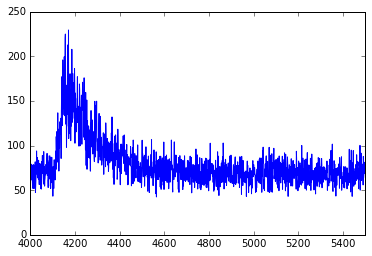

In [3]:
"""  Load Brightest Pulse """
p1 = np.load('ts2014-06-13T07:00:02.13597.npy')
p2 = np.load('ts2014-06-13T06:01:21.91125.npy')

data = p1.reshape(-1,4,6)
data = np.fft.rfft(data,axis=1)
plt.plot(abs(data).sum(1).sum(-1))
plt.xlim(4000,5500)

2.32586 4.38502
2.55447287128


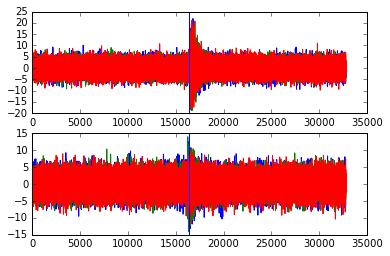

In [4]:
plt.subplot(211)
plt.plot(p1[:,1::2])
plt.axvline(2**14)

plt.subplot(212)
plt.plot(p2[:,1::2])
plt.axvline(2**14)

n_off = np.std(p1[:1024])
n_on  = np.std(p1[2**14:2**14+1024])

print n_off, n_on
print (n_on**2.0-n_off**2.0) / n_off**2.0

/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


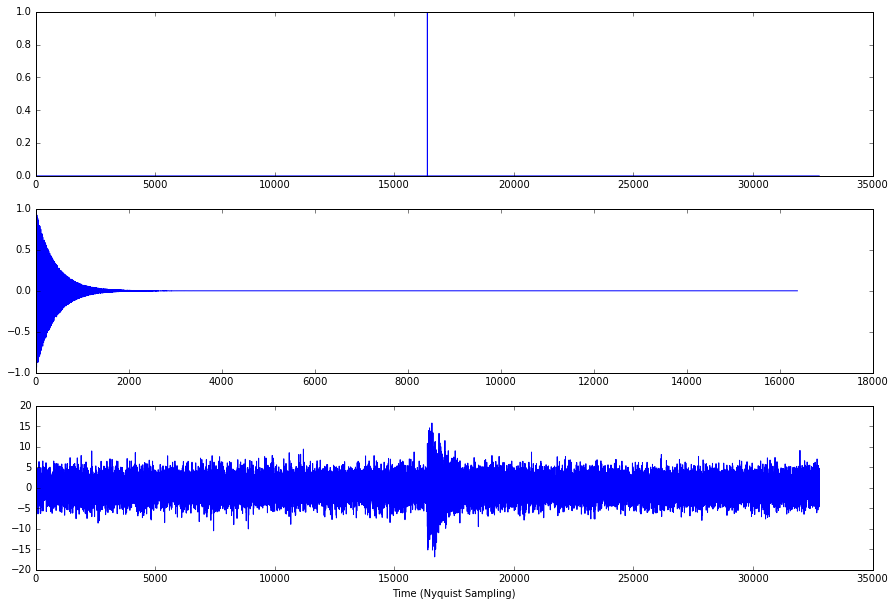

In [5]:
# Create exponential tail with 390 samples ~= 12.2microseconds
length = 2**15
t = np.arange(length)
#g = np.roll( np.exp(-t / 390.), length//2)
g = ( np.exp(-t / 390.) + 0j )[:length//2]
g *= np.exp(2j*np.pi*np.random.random(length//2))

ts = np.zeros(length)
ts[length//2] += 1

plt.figure(figsize=(15,10))

plt.subplot(311)
plt.plot(ts)

plt.subplot(312)
plt.plot(g)

irf = np.fft.fft(g)
irf = np.lib.pad(irf, (0,1), 'constant', constant_values=(0+0j))

ts_convolved = np.fft.irfft( (np.fft.rfft(ts) * irf) )

SN1 = 12
SN2 = 10

psim1 = SN1*ts_convolved + n_off*np.random.randn(length)
psim2 = SN2*ts_convolved + n_off*np.random.randn(length)

plt.subplot(313)
plt.plot(psim1)
plt.xlabel('Time (Nyquist Sampling)')


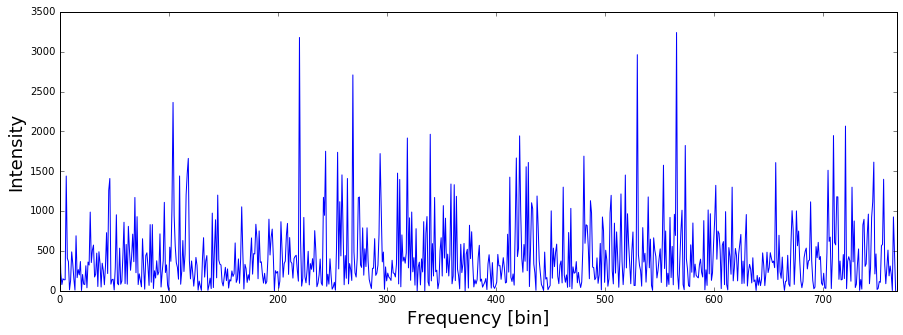

In [18]:
# Look at scintillations structure of simulated IRF
g_chan = np.fft.fft(g.reshape(-1,768), axis=1)

plt.figure(figsize=(15,5))
plt.plot(np.abs(g_chan[0])**2.0)

plt.xlim(0,768)
plt.ylabel('Intensity', fontsize=18)
plt.xlabel('Frequency [bin]', fontsize=18)

(-25, 25)

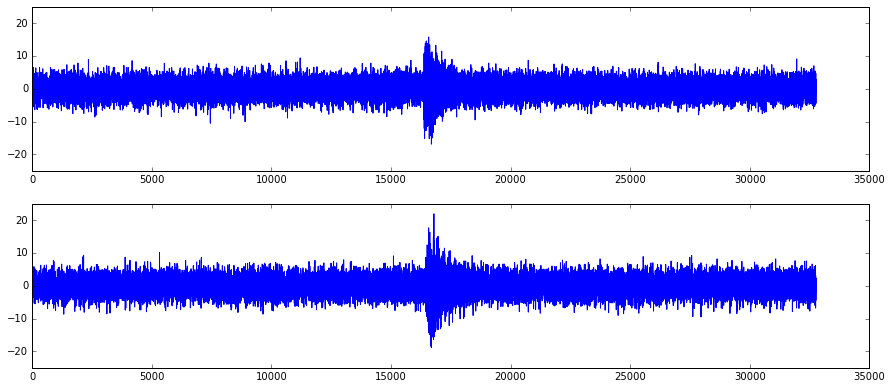

In [6]:
plt.figure(figsize=(15,10))

plt.subplot(311)
plt.plot(psim1)
plt.ylim(-25, 25)

plt.subplot(312)
plt.plot(p1[:,1])
plt.ylim(-25, 25)

In [7]:
def rechannelize(pulse, nchan):
    pulse = np.fft.irfft(pulse, axis=1)
    # Reshape to channels and keep polarization
    
    if len(pulse.shape) == 3:
        pulse = pulse.reshape(-1, 2*nchan, pulse.shape[-1])
    else:
        pulse = pulse.reshape(-1, 2*nchan)
    pulse = np.fft.rfft(pulse, axis=1)
    return pulse

def dechannelize(pulse):
    pulse = np.fft.irfft(pulse, axis=1)
    if len(pulse.shape) == 3:
        pulse = pulse.reshape(-1, pulse.shape[-1])
    else:
        pulse = pulse.ravel()
    return pulse

def correlate_power(p1, p2, cchan, fchan):
    p1fine = rechannelize(p1, fchan)
    p2fine = rechannelize(p2, fchan)
    p12_phased = (p1fine) * (abs(p2fine) / p2fine)
    p12_phased = rechannelize(p12_phased, cchan)
    return p12_phased

def correlate_returnts(p1, p2, fchan):
    p1fine = rechannelize(p1, fchan)
    p2fine = rechannelize(p2, fchan)
    p12_phased = (p1fine) * (abs(p2fine) / p2fine)
    p12_phased = dechannelize(p12_phased)
    return p12_phased

def Stokes(R,L):
    I = abs(R)**2.0 + abs(L)**2.0
    Q = 2*np.real(np.conj(L)*R)
    U = -2*np.imag(np.conj(L)*R)
    V = abs(R)**2.0 - abs(L)**2.0
    return I, Q, U, V

def channelize_ts(pulse, nchan):
    if len(pulse.shape) == 2:
        pulse = pulse.reshape(-1, 2*nchan, pulse.shape[-1])
    else:
        pulse = pulse.reshape(-1, 2*nchan)
    pulse = np.fft.rfft(pulse, axis=1)
    return pulse

def pad(ts,nzeros):
    ts = np.concatenate((ts,0*ts[:nzeros]), axis=0)
    return ts

153600
1.4480863651
1.21527040405


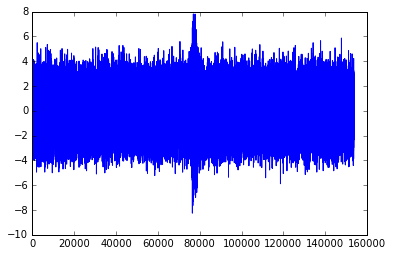

In [10]:
""" 
Compare to pipeline 

Pulses begin as shape (100, 768), with three 256 channel IFs combined

"""

""" Create Noise, SN values from real data """

nyq_pad = np.zeros((100,1))
p_comp = np.load('/media/drive2/b1957-GPs/RGPs/GP2014-06-13T07:00:02.13597.npy')
p_comp = np.load('/media/drive2/b1957-GPs/RGPs/GP2014-06-13T06:01:21.91125.npy')
#p_comp = np.load('/media/drive2/b1957-GPs/RGPs/GP2014-06-13T06:01:23.83362.npy')
p_comp = np.concatenate((p_comp,nyq_pad), axis=1)

ts_comp = dechannelize(p_comp)
length = len(ts_comp)
print length
t = np.arange(length)
n_off = np.std(ts_comp[:40000])

plt.plot(ts_comp)

""" First, generate 3 impulse responses for the different IFs """
g = ( np.exp(-t / 390. / 3.) + 0j )[:length//2]
g *= np.exp(2j*np.pi*np.random.random(length//2))
irf = np.fft.fft(g)
irf = np.lib.pad(irf, (0,1), 'constant', constant_values=(0+0j))

SN = np.std(ts_comp[76000:76000+1024*3])**2.0 / np.std(ts_comp[:1024*3])**2.0 - 1
print SN
print np.sqrt(1+SN**(-2.0))

2.14206992022
1.3759794722
2.1505445304
1.37446938948


(75000, 90000)

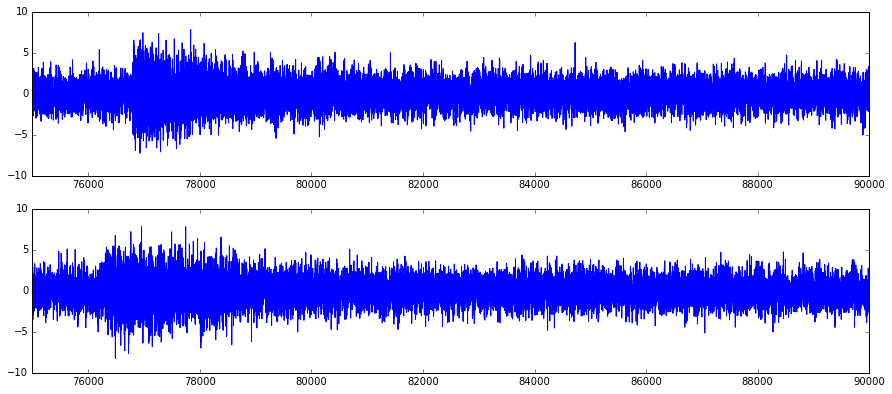

In [10]:
""" Generate two pulses with different SN but same IRF """

%matplotlib inline

p_irf = simGP(4, irf, n_off)

print(np.std(p_irf[76600:76600+1024*3]))
print(np.std(p_irf[:1024*3]))

print(np.std(ts_comp[76000:76000+1024*3]))
print(np.std(ts_comp[:1024*3]))

plt.figure(figsize=(15,10))

plt.subplot(311)
plt.plot(p_irf)
plt.ylim(-10, 10)
plt.xlim(75000,90000)

plt.subplot(312)
plt.plot(ts_comp)
plt.ylim(-10, 10)
plt.xlim(75000,90000)

plt.xlabel('Time (Nyquist Sampling)')

In [19]:
""" De-Scattering Loop """

cchan = 16*3
fchan = 512*3
pchan = 16*3 # Channelization of 1 microsecond to align profiles

cratio = pchan // cchan

td = []
pratio = []

p_irf = simGP(4, irf, n_off)
p_irf = np.roll(p_irf, int(np.random.randn(1)*len(irf)) )
p1 = channelize_ts(p_irf, 256*3)
p1prof = (abs(rechannelize(p1,pchan))**2.0).sum(-1)
p1temp = np.roll(rechannelize(p1,cchan), cratio*(514-np.argmax(p1prof)), axis=0)

for i in range(100):
    p2 = simGP(2.2, irf, n_off)
    p2 = np.roll(p2, int(np.random.randn(1)*len(irf)) )
    
    p2 = channelize_ts(p2, 256*3)
            
    p2prof = (abs(rechannelize(p2,pchan))**2.0).sum(-1)
    p2temp = np.roll(rechannelize(p2,cchan), cratio*(514-np.argmax(p2prof)), axis=0)

    p12pcorr = correlate_power(p2temp, p1temp, cchan, fchan)
    p11pcorr = correlate_power(p1temp, p1temp, cchan, fchan)
    p22pcorr = correlate_power(p2temp, p2temp, cchan, fchan)

    p11pcorr = (abs(p22pcorr)**2.0).sum(1)
    p22pcorr = (abs(p22pcorr)**2.0).sum(1)
            
    Npeak = p11pcorr.shape[0]*cchan/fchan
    p11max = max(p11pcorr) - np.sort(p11pcorr)[-Npeak:-2*(Npeak//50)].mean()
    p22max = max(p22pcorr) - np.sort(p22pcorr)[-Npeak:-2*(Npeak//50)].mean()
    corrnorm = 1.

    pcross = max( (abs(p12pcorr[cratio*511:cratio*577])**2.0).sum(1) ) - (
                abs(p12pcorr[cratio*50:cratio*450])**2.0).sum(1).mean(0) 

    pauto = np.sqrt(p11max*p22max)

    pratio.append(pcross / pauto)

sim_pcorr = (np.abs(p12pcorr)**2.0).sum(1)
sim_p11pcorr = p11pcorr
sim_p22pcorr = p22pcorr
test_sim = p1temp
pr1 = 1*np.array(pratio)
print pr1

[ 0.6045123   0.66135729  0.57993998  0.49720003  0.65455876  0.63506433
  0.57402128  0.52281036  0.61682341  0.61480823  0.52385983  0.61963605
  0.56970401  0.52190245  0.37611097  0.51364962  0.59466264  0.55214417
  0.60143655  0.62358074  0.56265546  0.58470215  0.62959427  0.55925048
  0.52182003  0.72936497  0.39321466  0.61734432  0.59952109  0.62809537
  0.56819067  0.62729803  0.6525462   0.55142263  0.53149256  0.61183952
  0.49182246  0.61189702  0.6004088   0.60773287  0.69868099  0.62367883
  0.64338806  0.59005185  0.55605047  0.60373593  0.58564402  0.61049509
  0.58491429  0.58213507  0.54886702  0.58181295  0.63219846  0.46896511
  0.4165982   0.57719525  0.61760814  0.5655113   0.55521793  0.56675108
  0.15714875  0.72822842  0.59813528  0.13919185  0.49192768  0.61758634
  0.6658493   0.5884478   0.59490115  0.61309783  0.67804884  0.58361992
  0.54006122  0.56197512  0.57183989  0.50027095  0.57874668  0.33129368
  0.57699928  0.6382862   0.45385083  0.66786028  0

[0.50448485106614016]


(448, 640)

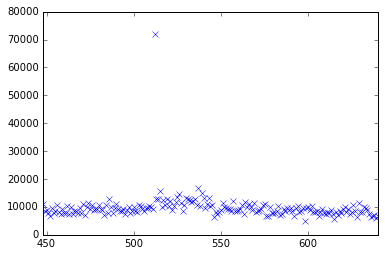

In [54]:
""" Real Example """

cchan = 16*3
fchan = 512*3
pchan = 16*3 # Channelization of 1 microsecond to align profiles

cratio = pchan // cchan

fig, ax1 = plt.subplots()

td = []
pratio = []

p1 = np.load('/media/drive2/b1957-GPs/RGPs/GP2014-06-13T06:01:21.91125.npy')
p1 = np.concatenate((p1,nyq_pad), axis=1)

p1prof = (abs(rechannelize(p1,pchan))**2.0).sum(-1)
p1temp = np.roll(rechannelize(p1,cchan), cratio*(519-np.argmax(p1prof)), axis=0)

p2 = np.load('/media/drive2/b1957-GPs/RGPs/GP2014-06-13T06:01:23.83362.npy')
p2 = np.concatenate((p2,nyq_pad), axis=1)
    
p2prof = (abs(rechannelize(p2,pchan))**2.0).sum(-1)
p2temp = np.roll(rechannelize(p2,cchan), cratio*(520-np.argmax(p2prof)), axis=0)

p12pcorr = correlate_power(p2temp, p1temp, cchan, fchan)
p11pcorr = correlate_power(p1temp, p1temp, cchan, fchan)
p22pcorr = correlate_power(p2temp, p2temp, cchan, fchan)

p11pcorr = (abs(p22pcorr)**2.0).sum(1)
p22pcorr = (abs(p22pcorr)**2.0).sum(1)
            
Npeak = p11pcorr.shape[0]*cchan/fchan
p11max = max(p11pcorr) - np.sort(p11pcorr)[-Npeak:-2*(Npeak//50)].mean()
p22max = max(p22pcorr) - np.sort(p22pcorr)[-Npeak:-2*(Npeak//50)].mean()
corrnorm = 1.

pcross = max( (abs(p12pcorr[cratio*511:cratio*577])**2.0).sum(1) ) - (
                abs(p12pcorr[cratio*50:cratio*450])**2.0).sum(1).mean(0) 

pauto = np.sqrt(p11max*p22max)
pratio.append(pcross / pauto)

real_pcorr = (np.abs(p12pcorr)**2.0).sum(1)
real_p11pcorr = p11pcorr
real_p22pcorr = p22pcorr

testreal = p1temp

print pratio

plt.plot((np.abs(p12pcorr)**2.0).sum(1), 'bx')

plt.xlim(512-64, 512+128)

0.57672407597 0.0934465142884
1.73393142694


NameError: name 'real_pcorr' is not defined

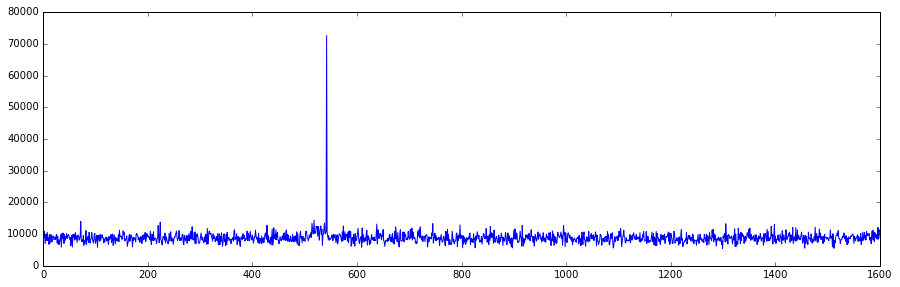

In [20]:
print np.mean(pr1), np.std(pr1)

sim = (np.abs(p12pcorr)**2.0).sum(1)

correction = 1 / np.mean(pr1)
print correction

plt.figure(figsize=(15,10))

plt.subplot(211)
plt.plot(sim_pcorr, 'b-', label='simulated')
plt.plot(real_pcorr, 'r-', label='real')

plt.xlim(512-64,512+128)
#plt.xlabel(r'Time $(\mu s)$', fontsize=18)
plt.title('De-scattered Power', fontsize=18)
plt.legend(fontsize=18)

plt.subplot(212)
plt.title('De-scattered Autocorrelation', fontsize=18)
plt.plot(sim_p22pcorr, 'b-')
plt.plot(real_p22pcorr, 'r-')
plt.xlabel(r'Time $(\mu s)$', fontsize=18)


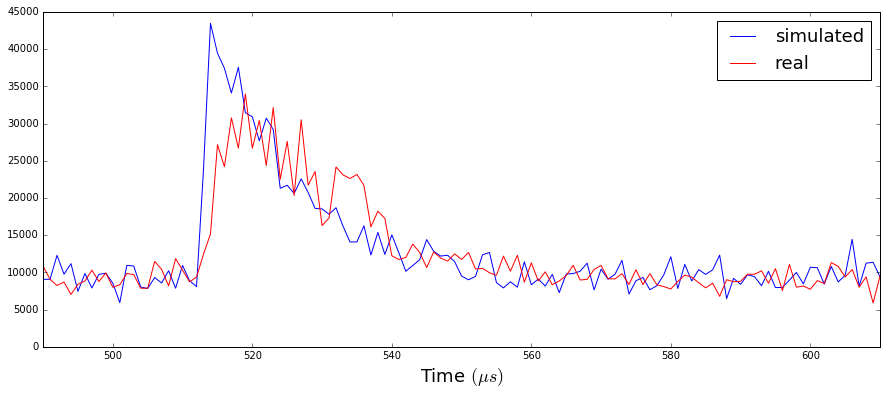

In [29]:

profreal = rechannelize(testreal, 16*3)
profsim = rechannelize(test_sim, 16*3)
#plt.xlim(75000,85000)


prof1 = (abs(profsim)**2.0).sum(1)
prof2 = (abs(profreal)**2.0).sum(1)
#SN = (prof - np.mean(prof[20:])) / np.std(prof[20:])

plt.figure(figsize=(15,6))
plt.plot(prof1, label='simulated')
plt.plot(prof2, 'r', label='real')

plt.xlim(490,610)
plt.xlabel(r'Time $(\mu s)$', fontsize=18)

plt.legend(fontsize=18)

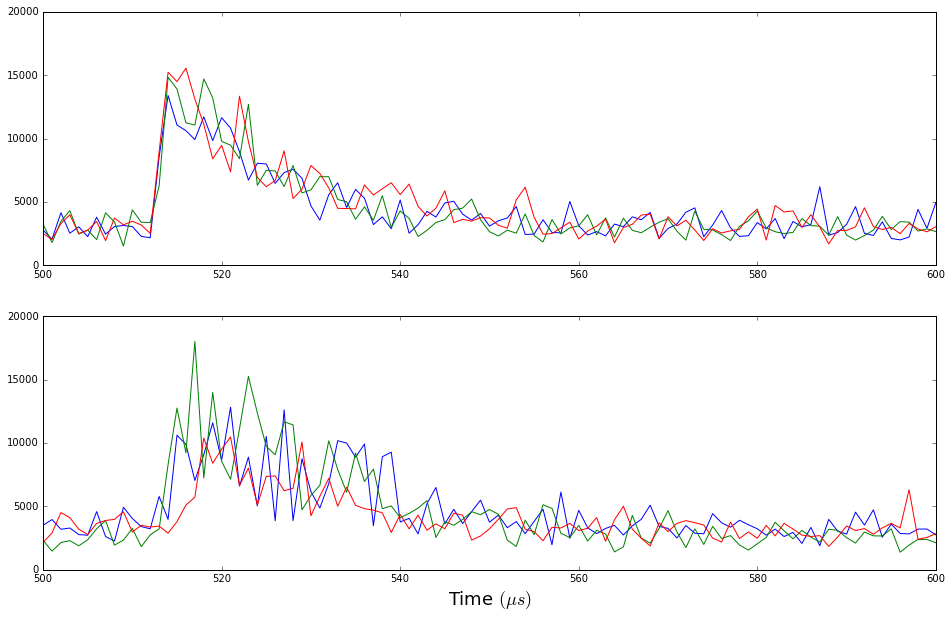

In [33]:
""" Check de-dispersion """

plt.figure(figsize=(16,10))

plt.subplot(211)
p = abs(profsim)**2.0
plt.plot(p[:,:16].sum(1))
plt.plot(p[:,16:32].sum(1))
plt.plot(p[:,32:].sum(1))
plt.xlim(500,600)
plt.ylim(0,20000)

plt.subplot(212)
p = abs(profreal)**2.0
plt.plot(p[:,:16].sum(1))
plt.plot(p[:,16:32].sum(1))
plt.plot(p[:,32:].sum(1))
plt.xlim(500,600)

plt.xlabel(r'Time $(\mu s)$', fontsize=18)

In [60]:
t = np.fft.irfft(irf)

t.shape

(153600,)

In [59]:
""" De-Scattering Loop to Determine SN corrections """

cchan = 16*3
fchan = 512*3
pchan = 16*3 # Channelization of 1 microsecond to align profiles

cratio = pchan // cchan

SN = []
P = []
Pnoise = []

# logarithmic spacing

for sn in np.linspace(0,1,20):
    pratio = []
    
    sntemp = []
    for x in range(10):
        p_irf = simGP(10**(sn), irf, n_off)
        sntemp.append(np.std(p_irf[76600:76600+1024*3])**2 / np.std(p_irf[:1024*3])**2 - 1 )
    sntemp = np.array(sntemp)    
    SN.append( np.mean(sntemp) )

    p_irf = np.roll(p_irf, int(np.random.randn(1)*len(irf)) )
    p1 = channelize_ts(p_irf, 256*3)

    p1prof = (abs(rechannelize(p1,pchan))**2.0).sum(-1)
    p1temp = np.roll(rechannelize(p1,cchan), cratio*(518-np.argmax(p1prof)), axis=0)

    for i in range(100):
        p2 = simGP(10**sn, irf, n_off)        
        p2 = np.roll(p2, int(np.random.randn(1)*len(irf)) )

        
        p2 = channelize_ts(p2, 256*3)

        p2prof = (abs(rechannelize(p2,pchan))**2.0).sum(-1)
        p2temp = np.roll(rechannelize(p2,cchan), cratio*(518-np.argmax(p2prof)), axis=0)

        p12pcorr = correlate_power(p2temp, p1temp, cchan, fchan)
        p11pcorr = correlate_power(p1temp, p1temp, cchan, fchan)
        p22pcorr = correlate_power(p2temp, p2temp, cchan, fchan)

        p11pcorr = (abs(p22pcorr)**2.0).sum(1)
        p22pcorr = (abs(p22pcorr)**2.0).sum(1)

        Npeak = p11pcorr.shape[0]*cchan/fchan
        p11max = max(p11pcorr) - np.sort(p11pcorr)[-Npeak:-2*(Npeak//50)].mean()
        p22max = max(p22pcorr) - np.sort(p22pcorr)[-Npeak:-2*(Npeak//50)].mean()
        corrnorm = 1.

        pcross = max( (abs(p12pcorr[cratio*511:cratio*577])**2.0).sum(1) ) - (
                    abs(p12pcorr[cratio*50:cratio*450])**2.0).sum(1).mean(0) 

        pauto = np.sqrt(p11max*p22max)

        pratio.append(pcross / pauto)
   
    pr1 = 1*np.array(pratio)

    P.append(pr1.mean())
    Pnoise.append(pr1.std())


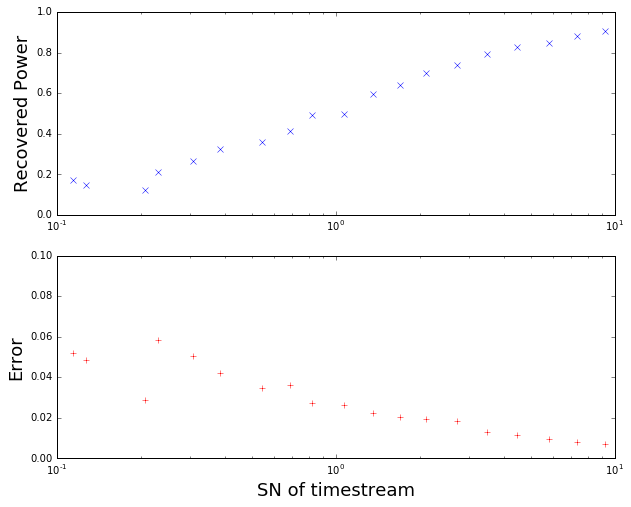

In [72]:
plt.figure(figsize=(10,8))

plt.subplot(211)
plt.plot(SN, P, 'bx')

plt.ylim(0,1)
plt.xscale('log')
plt.xlim(0.1,10)
plt.ylabel('Recovered Power', fontsize=18)

plt.subplot(212)
plt.plot(SN, Pnoise, 'r+')
plt.ylim(0,0.1)
plt.xlim(0.1,10)

plt.ylabel('Error', fontsize=18)
plt.xlabel('SN of timestream', fontsize=18)

plt.xscale('log')

In [96]:
xtest = SN[5:]
ytest1 = P[5:]
ytest2 = Pnoise[5:]

z = np.polyfit(xtest, ytest1, 5)
np.save('SNcorrectionPol.npy',z)
ptest1 = np.poly1d(z)

z = np.polyfit(xtest, ytest2, 5)
np.save('SNnoisePol.npy',z)
ptest2 = np.poly1d(z)

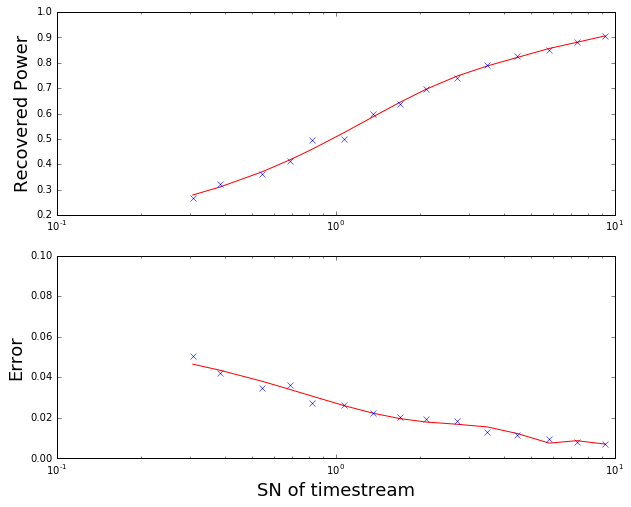

In [95]:
plt.figure(figsize=(10,8))

plt.subplot(211)
plt.plot(xtest, ptest1(xtest), 'r')
plt.plot(xtest, ytest1, 'bx')
plt.xscale('log')
plt.ylabel('Recovered Power', fontsize=18)

plt.subplot(212)
plt.plot(xtest, ptest2(xtest), 'r')
plt.plot(xtest, ytest2, 'bx')
plt.xscale('log')
plt.ylim(0,0.1)

plt.ylabel('Error', fontsize=18)
plt.xlabel('SN of timestream', fontsize=18)


In [82]:
""" Add  """

plt.figure(figsize=(10,8))

plt.subplot(211)
plt.plot(xtest, ptest1(xtest), 'r')
plt.plot(xtest, ytest1, 'bx')
plt.xscale('log')
plt.ylabel('Recovered Power', fontsize=18)

plt.subplot(212)
plt.plot(xtest, ptest2(xtest), 'r')
plt.plot(xtest, ytest2, 'bx')
plt.xscale('log')
plt.ylim(0,0.1)

plt.ylabel('Error', fontsize=18)
plt.xlabel('SN of timestream', fontsize=18)


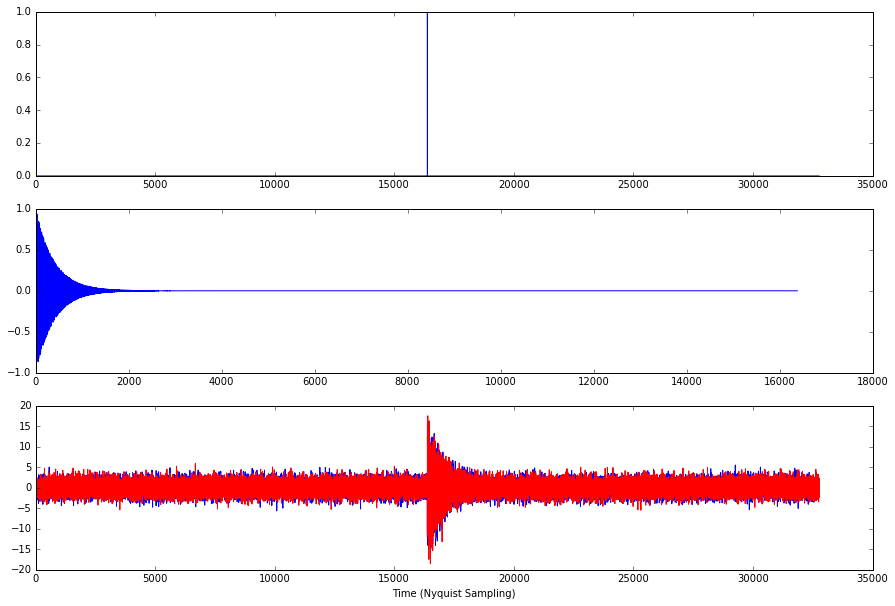

In [109]:
# Create exponential tail with 390 samples ~= 12.2microseconds
length = 2**15
t = np.arange(length)
#g = np.roll( np.exp(-t / 390.), length//2)
g = ( np.exp(-t / 390.) + 0j )[:length//2]
g *= np.exp(2j*np.pi*np.random.random(length//2))

ts = np.zeros(length)
ts[length//2] += 1

plt.figure(figsize=(15,10))

plt.subplot(311)
plt.plot(ts)

plt.subplot(312)
plt.plot(g)

irf1 = np.fft.fftshift( np.fft.fft(g) )
irf2 = np.fft.fft(g)
irf1 = np.lib.pad(irf1, (0,1), 'constant', constant_values=(0+0j))
irf2 = np.lib.pad(irf2, (0,1), 'constant', constant_values=(0+0j))

ts1_convolved = np.fft.irfft( (np.fft.rfft(ts) * irf1) )
ts2_convolved = np.fft.irfft( (np.fft.rfft(ts) * irf2) )

SN = 12

psim1 = SN*ts1_convolved + n_off*np.random.randn(length)
psim2 = SN*ts1_convolved + n_off*np.random.randn(length)

plt.subplot(313)
plt.plot(psim1)
plt.plot(psim2, 'r')
plt.xlabel('Time (Nyquist Sampling)')


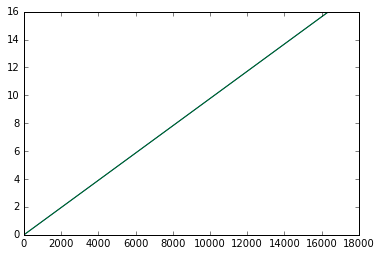

In [106]:
import astropy.units as u
plt.plot( np.roll( np.fft.fftfreq(len(g)) * 16*u.MHz, length//4 ) + 8*u.MHz)
plt.plot(np.fft.rfftfreq(length) * 32*u.MHz)